In [41]:
import json
import random
import numpy as np
import tensorflow as tf
from collections import deque
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D
from keras import backend as K
import datetime
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import time
import math

from matplotlib.colors import LinearSegmentedColormap
import colorsys
import numpy as np
    
from data_retrieval_relocation_3ksol_reloc import INSTANCEProvider
from kbh_yard_b2b_relocation import KBH_Env                               #This is the environment of the shunting yard
from dqn_kbh_colfax_relocation_test_agent import DQNAgent

In [42]:
# this function returns random colors for visualisation of learning.
def rand_cmap(nlabels, type='soft', first_color_black=True, last_color_black=False):
    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)
    return random_colormap


In [43]:
#1525336829 is the 150k expensive relocation model.

In [44]:
for model_nr in ['1525336829']:
    #which model to load.
    test_case = model_nr
    
    #LOAD THE INSTANCE PROVIDER
    ig = INSTANCEProvider()
    instances = ig.instances
    # Create environment KBH
    yrd = KBH_Env()

    # Create the DQNAgent with the CNN approximation of the Q-function and its experience replay and training functions.
    # load the trained model.
    agent = DQNAgent(yrd, True, test_case)

    # set epsilon to 0 to act just greedy
    agent.epsilon = 0

    #new_cmap = rand_cmap(200, type='soft', first_color_black=True, last_color_black=False, verbose=True)
    
    visualization = False
    
    n = len(instances)
    
    # result vectors
    original_lengths = []
    terminated_at_step = []
    success = []
    relocations = []
    print_count = 0
    
    
    # train types different tracks? 
    type_step_track = []
    
       
    for instance in instances:
        nr_relocations = 0
        if print_count % 100 == 0:
            print(print_count)
        print_count = print_count + 1
        #Initialize problem
        event_list = ig.get_instance(instance)
        
        steps, t, total_t, score= len(event_list), 0, 0, 0

        state = yrd.reset(event_list)  # Get first observation based on the first train arrival.
        history = np.reshape(state, (
            1, yrd.shape[0], yrd.shape[1], yrd.shape[2]))  # reshape state into tensor, which we call history.

        done, busy_relocating = False, False
        
        if visualization:
            #visualize learning
            new_cmap = rand_cmap(200, type='soft', first_color_black=True, last_color_black=False)

        if visualization == True:
            plt.imshow(np.float32(history[0][0]), cmap=new_cmap, interpolation='nearest')
            plt.show()

        while not done:
            action = agent.get_action(history)  # RL choose action based on observation

            if visualization == True:
                print(agent.model.predict(history))
                print(action+1)
#             # RL take action and get next observation and reward
#             # note the +1 at action

            # save for arrival activities the parking location
            event_list_temp = event_list.reset_index(drop=True).copy()
            if event_list_temp.event_type[0]=='arrival':
                train_type = event_list_temp.composition[0]
                type_step_track.append({'type': train_type, 'action': action+1, 'step':t, 'instance_id': instance})


            # based on that action now let environment go to new state
            event = event_list.iloc[0]
            # check if after this we are done... 
            done_ = True if len(event_list) == 1 else False  # then there is no next event
#             if done_:
#                 print("Reached the end of a problem!")
            if busy_relocating:
                # here we do not drop an event from the event list.
                coming_arrivals = event_list.loc[event_list['event_type'] == 'arrival'].reset_index(drop=True)
                coming_departures = event_list.loc[event_list['event_type'] == 'departure'].reset_index(drop=True)

                next_state, reward, done = yrd.reloc_destination_step(event, event_list, action+1, coming_arrivals, coming_departures, done_)
                nr_relocations += 1
                busy_relocating = False
            else: 
                # These operations below are expensive: maybe just use indexing.
                event_list.drop(event_list.index[:1], inplace=True)
                coming_arrivals = event_list.loc[event_list['event_type'] == 'arrival'].reset_index(drop=True)
                coming_departures = event_list.loc[event_list['event_type'] == 'departure'].reset_index(drop=True)

                # do step
                next_state, reward, done = yrd.step(action+1, coming_arrivals, coming_departures, event, event_list, done_)

                busy_relocating = True if reward == -0.5 else False

            history_ = np.float32(np.reshape(next_state, (1, yrd.shape[0], yrd.shape[1], yrd.shape[2])))
            
            score += reward  # log direct reward of action

            if visualization == True: 
                #show action
                plt.imshow(np.float32(history_[0][0]), cmap=new_cmap, interpolation='nearest')
                plt.show()
                time.sleep(0.05)
                if reward == -1:
                    time.sleep(1)
                print(reward)

            if done:  # based on what the environment returns.
                #print('ended at step' , t+1)
                #print('original length', steps)
                original_lengths.append(steps)
                terminated_at_step.append(t+1)
                relocations.append(nr_relocations)
                if int(np.unique(history_)[0]) == 1: #then we are in win state
                    success.append(1)
                else: 
                    success.append(0)
                break;

            history = history_  # next state now becomes the current state.
            t += 1  # next step in this episode
    
    #save data needed for Entropy calculations.
    df_type_step_track = pd.DataFrame.from_records(type_step_track)
    df_type_step_track['strtype'] = df_type_step_track.apply(lambda row: str(row.type), axis = 1)
    df_type_step_track.strtype = df_type_step_track.strtype.astype('category')
    filename = 'data_'+model_nr+'_relocation_arrival_actions.csv'
    df_type_step_track.to_csv(filename)
    
#     analysis_runs = pd.DataFrame(
#     {'instance_id': instances,
#      'original_length': original_lengths,
#      'terminated_at_step': terminated_at_step
#     })
 
#     analysis_runs['solved'] = analysis_runs.apply(lambda row: 1 if row.original_length == row.terminated_at_step else 0, axis =1 )
#     analysis_runs['tried'] = analysis_runs.apply(lambda row: 1 if row.terminated_at_step != -1 else 0, axis =1)
#     analysis_runs['percentage'] = analysis_runs.apply(lambda row: row.solved/755, axis=1)
    
#     analysis_runs.to_csv('best_model_solved_instances.csv')
#     print('Model: ', model_nr)
#     summary = analysis_runs.groupby('original_length', as_index=False)[['solved', 'tried', 'percentage']].sum()
#     print(summary)
    
#     #print hist
#     %matplotlib inline  
#     #%%
#     # analyse the parking actions per step and train type
#     df_type_step_track = pd.DataFrame.from_records(type_step_track)
#     bins = [1,2,3,4,5,6,7,8,9,10]
#     plt.hist(df_type_step_track.action, bins, align='left')
    
#     #prepare for save
#     df_type_step_track['strtype'] = df_type_step_track.apply(lambda row: str(row.type), axis = 1)
#     df_type_step_track.strtype = df_type_step_track.strtype.astype('category')
#     filename = 'data_'+model_nr+'_paper.csv'
#     df_type_step_track.to_csv(filename)





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 1, 33, 32)         16928     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 33, 64)         8256      
_________________________________________________________________
flatten_7 (Flatten)          (None, 2112)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               540928    
_________________________________________________________________
dense_14 (Dense)             (None, 9)                 2313      
Total params: 568,425
Trainable params: 568,425
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv

In [45]:
analysis_runs = pd.DataFrame(
{'instance_id': instances,
 'original_length': original_lengths,
 'terminated_at_step': terminated_at_step,
 'success': success,
 'nr_relocations': relocations
})


In [46]:
analysis_runs.sort_values('terminated_at_step')

,instance_id,nr_relocations,original_length,success,terminated_at_step
2594,6594,0,46,0,10
2827,6827,0,46,0,11
2859,6859,0,46,0,11
2289,6289,0,46,0,11
1880,5880,0,43,0,11
2303,6303,0,46,0,12
2627,6627,0,46,0,12
2793,6793,0,46,0,12
2833,6833,0,46,0,12
281,4281,1,37,0,12


In [47]:
print(analysis_runs.loc[analysis_runs.success == 0].instance_id.to_string(index=False))

4000
4002
4006
4009
4010
4012
4020
4021
4022
4028
4030
4031
4045
4055
4057
4058
4062
4063
4066
4083
4089
4090
4091
4096
4109
4119
4120
4122
4123
4126
4140
4141
4142
4170
4175
4188
4192
4201
4205
4209
4211
4218
4219
4220
4231
4260
4267
4281
4295
4303
4305
4318
4320
4322
4332
4335
4336
4339
4345
4348
4355
4358
4362
4372
4374
4411
4417
4422
4430
4434
4468
4482
4484
4503
4505
4520
4531
4536
4549
4552
4556
4559
4561
4565
4569
4583
4584
4595
4601
4602
4608
4617
4631
4632
4644
4645
4646
4677
4681
4690
4692
4693
4699
4701
4717
4726
4732
4756
4767
4768
4770
4777
4782
4793
4799
4803
4812
4817
4821
4823
4826
4827
4835
4852
4854
4858
4863
4883
4896
4904
4913
4917
4925
4928
4930
4941
4942
4943
4947
4955
4960
4973
4974
4984
4988
4989
4990
5001
5008
5011
5013
5016
5027
5031
5037
5040
5046
5048
5061
5063
5067
5070
5077
5079
5080
5089
5092
5103
5108
5113
5115
5149
5152
5153
5155
5159
5166
5167
5176
5182
5185
5186
5191
5197
5201
5210
5211
5217
5218
5227
5230
5239
5263
5266
5267
5268
5274
5279
5280
5296


In [48]:
analysis_runs.loc[analysis_runs.success == 1].copy().groupby('nr_relocations')[['instance_id']].count()

,instance_id
nr_relocations,
0,1749
1,627
2,82
3,7
4,2


In [49]:
summary = analysis_runs.groupby('original_length', as_index=False)[['success']].sum()
print(summary)


   original_length  success
0               37      648
1               41      621
2               43      626
3               46      572


In [50]:
summary = analysis_runs.groupby('original_length', as_index=False)[['success']].mean()
print(summary)

   original_length   success
0               37  0.858278
1               41  0.822517
2               43  0.829139
3               46  0.757616


4


(array([  2.08600000e+03,   8.08000000e+02,   1.13000000e+02,
          1.10000000e+01,   2.00000000e+00]),
 array([0, 1, 2, 3, 4, 5]),
 <a list of 5 Patch objects>)

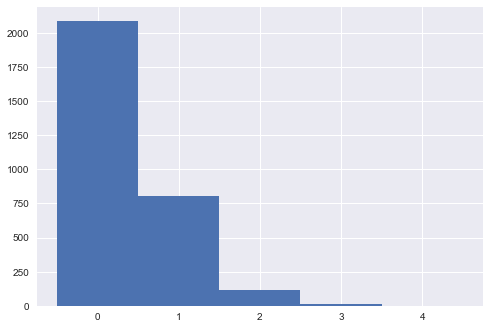

In [51]:
max_reloc = max(analysis_runs.nr_relocations)
print(max_reloc)
plt.hist(analysis_runs.nr_relocations, bins=range(0,max_reloc+2), align='left')


   original_length  nr_relocations
0               37        0.300926
1               41        0.323671
2               43        0.335463
3               46        0.374126


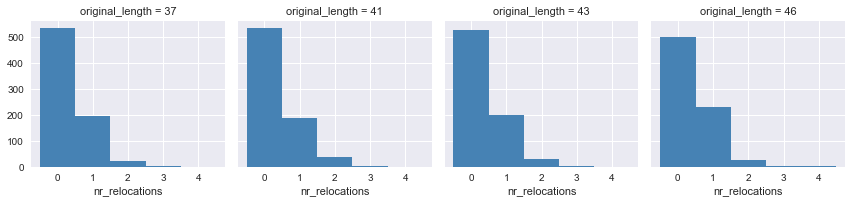

In [52]:
import seaborn as sns
sns.set(style="darkgrid")

g = sns.FacetGrid(analysis_runs, col="original_length", margin_titles=True)
bins = range(0,max_reloc+2)
g.map(plt.hist, "nr_relocations", color="steelblue", bins=bins, lw=0, align='left')

print(analysis_runs.loc[analysis_runs.success == 1].groupby('original_length', as_index=False)[['nr_relocations']].mean())

# CODE HAS BEEN RUN UNTILL HERE.
.

.

.

.

.

.

.

.

v






# analysis of mistakes



In [21]:
analysis_runs.loc[analysis_runs.success == 0].sort_values('terminated_at_step')

,instance_id,nr_relocations,original_length,success,terminated_at_step
1511,5511,0,43,0,9
2734,6734,0,46,0,9
2035,6035,0,43,0,9
2407,6407,0,46,0,10
2624,6624,0,46,0,10
2359,6359,0,46,0,10
2303,6303,0,46,0,10
2266,6266,0,46,0,10
2181,6181,0,43,0,10
2169,6169,0,43,0,10


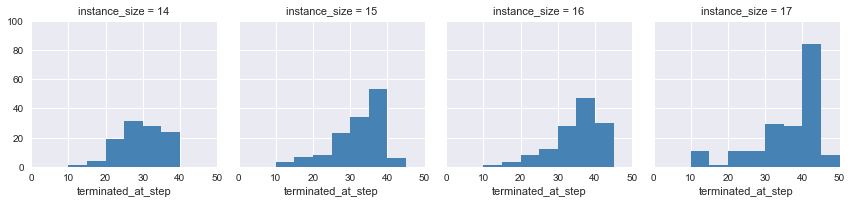

In [75]:
#plt.hist(analysis_runs.loc[analysis_runs.success == 0].terminated_at_step, bins=8)

len(analysis_runs.loc[analysis_runs.success == 0])

analysis_runs['instance_size'] = analysis_runs.apply(lambda row: str(row.original_length).replace('37', '14').replace('41', '15').replace('43', '16').replace('46','17'), axis=1)

import seaborn as sns
sns.set(style="darkgrid")


bins = [0,5,10,15,20,25,30,35,40,45,50]
g = sns.FacetGrid(analysis_runs.loc[analysis_runs.success == 0], col="instance_size", margin_titles=True)
g.set(ylim=(0, 100), xlim=(0,50))
g.map(plt.hist, "terminated_at_step", color="steelblue", bins = bins, lw=0)

sns.plt.savefig('150k_failures.eps')